In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [ ]:
Cox Proportional Hazards is one of the most popular methods for Survival Analysis.
This is in part due to CPH being a semi-parametric model, which means that your outcome variable 
does not need to adhere to a specific distribution. Further, CPH is known to fit various distributions fairly well.

The key assumption that underpins this method is referred to as the proportional hazards assumption. 

In [ ]:
For survival analysis, why we use semi-parametric models (Cox proportional hazards) instead of fully parametric
models?
If you know the parametric distribution that your data follows then using a maximum likelihood approach
and the distribution makes sense. The real advantage of Cox Proportional Hazards regression is that you can still 
fit survival models without knowing (or assuming) the distribution. 
For example, we may use the normal distribution, but most survival times 
do not come close to following a normal distribution. Some may follow a log-normal, or a Weibull, or other 
parametric distribution, and if you are willing to make that assumption then the maximum likelihood parametric
approach is great. But in many real world cases we do not know what the appropriate distribution is (or even a 
close enough approximation). With censoring and covariates we cannot do a simple histogram 
and say "that looks like a ... distribution to me". So it is very useful to have a technique that works 
well without needing a specific distribution.

https://stats.stackexchange.com/questions/64739/in-survival-analysis-why-do-we-use-semi-parametric-models-cox-proportional-haz

In [ ]:
Why use the hazard instead of the distribution function?
Consider the following statement: "People in group A are twice as likely to die at age 80 as people in group B".
Now that could be true because people in group B tend to live longer than those in group A, or it could be because 
people in group B tend to live shorter lives and most of them are dead long before age 80, giving a very small 
probability of them dying at 80 while enough people in group A live to 80 that a fair number of them will die at
that age giving a much higher probability of death at that age. So the same statement could mean being in group A 
is better or worse than being in group B. What makes more sense is to say, of those people (in each group) that 
lived to 80, what proportion will die before they turn 81. That is the hazard (and the hazard is a function of the 
distribution function/survival function/etc.). The hazard is easier to work with in the semi-parametric model and 
can then give you information about the distribution.

In [ ]:
Possible Regression Models to be fitted
1 Semi-parametric Cox Reg model
2 Parametric models to consider 
     -Accelerated failure time models (AFT models most common)
           ie The Weibull AFT model, The log-normal, log-logistic AFT models etc
     -fully parametric Cox Reg model using ie splines,
     - Aalen’s additive model still experimental

In [ ]:
Cox regression models may be compared using 
-AIC (it’s a trade off between maximizing the log-likelihood with as few parameters as possible)
-concordance index(seminparametric)
-Selecting a parametric model using QQ plots etc

In [3]:
#loading data
dataset_survival = pd.read_csv('dataset_survival.csv', encoding="latin1", low_memory=False)
dataset_survival.drop(columns=dataset_survival.columns[0], axis=1, inplace=True)

In [4]:
dataset_survival.head(10)

,DON_RACE,DON_A1,DON_A2,DON_B1,DON_B2,DON_DR1,DON_DR2,PERS_ID,CAN_RACE,REC_A1,...,PERS_OPTN_DEATH_DT,PERS_RESTRICT_DEATH_DT,TFL_DEATH_DT,TFL_LAFUDATE,TFL_ENDTXFU,PS,KGL,DCGL,GL,DAYS
0,White,1.0,11.0,35.0,60.0,1.0,8.0,3759020.0,White,11.0,...,NaN,NaN,NaN,2018-04-12,2018-11-21,0.0,0.0,0,0.0,1969
1,White,24.0,68.0,60.0,62.0,4.0,13.0,3147238.0,Black or African American,31.0,...,NaN,NaN,NaN,2017-10-24,2018-10-20,0.0,1.0,0,1.0,1831
2,White,1.0,2.0,7.0,8.0,17.0,4.0,2599447.0,Black or African American,203.0,...,NaN,NaN,NaN,2017-02-09,2018-10-01,0.0,0.0,0,0.0,1593
3,Black or African American,30.0,74.0,8.0,63.0,17.0,7.0,3257192.0,Black or African American,1.0,...,NaN,NaN,NaN,2013-01-08,2018-12-31,0.0,1.0,0,1.0,9
4,White,2.0,11.0,51.0,55.0,4.0,11.0,2619730.0,White,3.0,...,2017-09-05,NaN,NaN,2015-01-19,2018-10-06,1.0,1.0,0,1.0,836
5,Black or African American,68.0,68.0,53.0,72.0,12.0,13.0,2663909.0,Black or African American,23.0,...,NaN,NaN,NaN,2012-08-22,2019-08-18,0.0,1.0,0,1.0,5
6,White,1.0,23.0,13.0,38.0,4.0,14.0,2906016.0,Asian,2.0,...,NaN,NaN,NaN,2018-10-23,2018-10-29,0.0,0.0,0,0.0,2186
7,White,11.0,32.0,51.0,60.0,1.0,4.0,3147315.0,Black or African American,2.0,...,2015-04-09,NaN,NaN,2016-07-27,2019-07-28,1.0,0.0,1,1.0,1461
8,White,2.0,32.0,50.0,60.0,8.0,15.0,3265224.0,White,3.0,...,NaN,NaN,NaN,2018-07-18,2018-11-19,0.0,0.0,0,0.0,2068
9,Black or African American,1.0,2.0,35.0,81.0,17.0,11.0,2870483.0,Black or African American,23.0,...,NaN,NaN,NaN,2019-05-24,2018-09-13,0.0,0.0,0,0.0,2445


In [5]:
#transplant info dataset
tx_ki = pd.read_sas('/home/kidneyData/DATA_SP_2020/tx_ki.sas7bdat')

In [6]:
tx_ki.head()

,ORG_TY,PERS_ID,REC_TX_DT,REC_POSTX_LOS,PX_ID,REC_A_MM_EQUIV_TX,REC_A_MM_EQUIV_CUR,REC_B_MM_EQUIV_TX,REC_B_MM_EQUIV_CUR,REC_DR_MM_EQUIV_TX,...,TFL_COD,PERS_RELIST,PERS_RETX,PERS_RETX_TRR_ID,TFL_LAFUDATE,REC_MM_EQUIV_TX,REC_MM_EQUIV_CUR,PERS_OPTN_COD,DONOR_ID,DONOR_ID_VESSEL
0,b'KI',4956632.0,2012-11-20,5.0,853031.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaT,NaT,NaN,2018-04-12,3.0,3.0,NaN,419584.0,NaN
1,b'KI',4787788.0,2012-10-19,5.0,736755.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2013-08-21,NaT,NaN,2017-10-24,0.0,0.0,NaN,418721.0,NaN
2,b'KI',4059261.0,2012-09-30,6.0,575654.0,2.0,2.0,2.0,2.0,0.0,...,NaN,NaT,NaT,NaN,2017-02-09,4.0,4.0,NaN,417693.0,NaN
3,b'KI',4893631.0,2012-12-30,9.0,785678.0,1.0,1.0,2.0,2.0,2.0,...,NaN,2013-01-02,2018-02-07,773433.0,2013-01-08,5.0,5.0,NaN,422447.0,NaN
4,b'KI',4573989.0,2012-10-05,2.0,664555.0,1.0,1.0,2.0,2.0,1.0,...,NaN,NaT,NaT,NaN,2015-01-19,4.0,4.0,NaN,417628.0,NaN


In [6]:
#merge with tx_ki dataset
dataset_survival = dataset_survival.merge(tx_ki, left_index=True, right_index=True,
             on='PERS_ID', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [26]:
dataset_reg = dataset_survival[[
 'REC_AGE_AT_TX', 
 'DON_AGE',  
 'CAN_LAST_SRTR_PEAK_PRA',
 'REC_DIAL_TY',
 'DON_RACE', 
 'CAN_RACE', 
 'CAN_GENDER',
 'DON_GENDER', 
 'GL',  
 'DAYS', 
 'REC_BMI',
 'REC_HGT_CM',
 'CAN_HGT_CM',
 'CAN_WGT_KG',
 'REC_WGT_KG',
 'DON_HGT_CM',
 'DON_WGT_KG',
 'REC_PRIMARY_PAY', 
 'REC_COLD_ISCH_TM',
 'REC_TX_DT']]

#### DON_BMI calculation

In [ ]:
def bmi(x):
    return x.DON_WGT_KG/((x.DON_HGT_CM/100)**2)

dataset_reg['DON_BMI'] = dataset_reg.apply(lambda x: bmi(x), axis=1)

In [28]:
dataset_reg = dataset_reg[[
 'REC_AGE_AT_TX', 
 'DON_AGE',  
 'CAN_LAST_SRTR_PEAK_PRA',
 'DON_RACE', 
 'CAN_RACE', 
 'CAN_GENDER',
 'DON_GENDER', 
 'GL',  
 'DAYS', 
 'DON_BMI',
 'REC_BMI',
 'REC_PRIMARY_PAY',  
 'REC_COLD_ISCH_TM',
 'REC_TX_DT' 
]]

In [29]:
dataset_reg.head()

,REC_AGE_AT_TX,DON_AGE,CAN_LAST_SRTR_PEAK_PRA,DON_RACE,CAN_RACE,CAN_GENDER,DON_GENDER,GL,DAYS,DON_BMI,REC_BMI,REC_PRIMARY_PAY,REC_COLD_ISCH_TM,REC_TX_DT
0,30.0,28.0,6.0,White,White,b'M',b'F',0.0,1969,30.725868,23.5313,1.0,3.00,2012-11-20
1,26.0,53.0,13.0,White,Black or African American,b'M',b'F',1.0,1831,23.336063,30.7476,4.0,17.43,2012-09-30
2,42.0,53.0,0.0,White,Black or African American,b'M',b'F',0.0,1593,27.365657,37.2840,4.0,18.16,2012-12-30
3,62.0,17.0,NaN,Black or African American,Black or African American,b'F',b'F',1.0,9,27.412446,26.8625,2.0,21.00,2012-10-05
4,68.0,59.0,19.0,White,White,b'M',b'M',1.0,836,40.740741,32.7399,3.0,14.40,2012-08-17


### Preprocessing some features

##### REC_AGE_AT_TX, DON AGE

In [30]:
# REC_AGE_AT_TX, DON AGE # changed to 18-34, 34-49, 50 or more
def age_group(age):
    if age <= 34:  
        return "18-34"
    elif age <= 49: 
        return "35 - 49"
    else:           
        return "> 45"


dataset_reg['REC_AGE_AT_TX'] = dataset_reg['REC_AGE_AT_TX'].apply(age_group)
dataset_reg['DON_AGE'] = dataset_reg['DON_AGE'].apply(age_group)

##### PRA CAN_LAST_SRTR_PEAK_PRA

In [31]:
def PRA_group(age):
    if age <= 19:  
        return "0-19"
    elif age <= 95: 
        return "19 - 95"
    else:           
        return "> 95"


dataset_reg['CAN_LAST_SRTR_PEAK_PRA'] = dataset_reg['CAN_LAST_SRTR_PEAK_PRA'].apply(PRA_group)

##### RACE

In [32]:
def race_label(race):
    if race == "White":
        return "White"
    elif race == "Black or African American": 
        return "Black"
    else:
        return "All Others"

# Apply race_label function to DON_RACE column
dataset_reg['DON_RACE'] = dataset_reg['DON_RACE'].apply(race_label)
# Apply race_label function to CAN_RACE column
dataset_reg['CAN_RACE'] = dataset_reg['CAN_RACE'].apply(race_label)

##### REC BMI, DON BMI

In [33]:
def BMI_group(bmi):
    if bmi <= 30:  
        return "0-30"
    else:           
        return "> 30"


dataset_reg['REC_BMI'] = dataset_reg['REC_BMI'].apply(BMI_group)
dataset_reg['DON_BMI'] = dataset_reg['DON_BMI'].apply(BMI_group)

##### REC_PRIMARY_PAY

In [34]:
def pay_label(pay):
    if pay == 1:
        return "Private insurance"
    elif pay == 2: 
        return "Public insurance"
    else:
        return "All Others"


dataset_reg['REC_PRIMARY_PAY'] = dataset_reg['REC_PRIMARY_PAY'].apply(pay_label)

##### REC_COLD_ISCH_TM

In [35]:
def cold_group(time):
    if time <= 24:  
        return "0-24"
    else:           
        return "> 24"

    
dataset_reg['REC_COLD_ISCH_TM'] = dataset_reg['REC_COLD_ISCH_TM'].apply(cold_group)

##### REC_TX_DT

In [36]:
def transp_era(time):
    if time < "2010-01-01": 
        return "Before 2010"
    else:           
        return "2011 and after"

    
dataset_reg['REC_TX_DT'] = dataset_reg['REC_TX_DT'].apply(transp_era)

In [37]:
dataset_reg.REC_TX_DT.value_counts()

2011 and after    71865
Before 2010        9139
Name: REC_TX_DT, dtype: int64

In [38]:
dataset_reg.head(20)

,REC_AGE_AT_TX,DON_AGE,CAN_LAST_SRTR_PEAK_PRA,DON_RACE,CAN_RACE,CAN_GENDER,DON_GENDER,GL,DAYS,DON_BMI,REC_BMI,REC_PRIMARY_PAY,REC_COLD_ISCH_TM,REC_TX_DT
0,18-34,18-34,0-19,White,White,b'M',b'F',0.0,1969,> 30,0-30,Private insurance,0-24,2011 and after
1,18-34,> 45,0-19,White,Black,b'M',b'F',1.0,1831,0-30,> 30,All Others,0-24,2011 and after
2,35 - 49,> 45,0-19,White,Black,b'M',b'F',0.0,1593,0-30,> 30,All Others,0-24,2011 and after
3,> 45,18-34,> 95,Black,Black,b'F',b'F',1.0,9,0-30,0-30,Public insurance,0-24,2011 and after
4,> 45,> 45,0-19,White,White,b'M',b'M',1.0,836,> 30,> 30,All Others,0-24,2011 and after
5,35 - 49,35 - 49,0-19,Black,Black,b'M',b'F',1.0,5,> 30,0-30,All Others,0-24,2011 and after
6,> 45,18-34,0-19,White,All Others,b'M',b'F',0.0,2186,> 30,0-30,All Others,0-24,2011 and after
7,35 - 49,18-34,0-19,White,Black,b'M',b'M',1.0,1461,> 30,0-30,All Others,0-24,2011 and after
8,> 45,35 - 49,0-19,White,White,b'M',b'F',0.0,2068,> 30,0-30,All Others,0-24,2011 and after
9,> 45,> 45,0-19,Black,Black,b'F',b'F',0.0,2445,0-30,> 30,Private insurance,0-24,2011 and after


### CREATING DUMMY VARIABLES FOR CATEGORICAL FEATURES

In [39]:
dataset_reg=pd.get_dummies(dataset_reg) #uses drop_first=False by default
dataset_reg.columns

Index(['GL', 'DAYS', 'REC_AGE_AT_TX_18-34', 'REC_AGE_AT_TX_35 - 49',
       'REC_AGE_AT_TX_> 45', 'DON_AGE_18-34', 'DON_AGE_35 - 49',
       'DON_AGE_> 45', 'CAN_LAST_SRTR_PEAK_PRA_0-19',
       'CAN_LAST_SRTR_PEAK_PRA_19 - 95', 'CAN_LAST_SRTR_PEAK_PRA_> 95',
       'DON_RACE_All Others', 'DON_RACE_Black', 'DON_RACE_White',
       'CAN_RACE_All Others', 'CAN_RACE_Black', 'CAN_RACE_White',
       'CAN_GENDER_b'F'', 'CAN_GENDER_b'M'', 'DON_GENDER_b'F'',
       'DON_GENDER_b'M'', 'DON_BMI_0-30', 'DON_BMI_> 30', 'REC_BMI_0-30',
       'REC_BMI_> 30', 'REC_PRIMARY_PAY_All Others',
       'REC_PRIMARY_PAY_Private insurance', 'REC_PRIMARY_PAY_Public insurance',
       'REC_COLD_ISCH_TM_0-24', 'REC_COLD_ISCH_TM_> 24',
       'REC_TX_DT_2011 and after', 'REC_TX_DT_Before 2010'],
      dtype='object')

In [40]:
# Address Multi-Collinearity
# drop unnecessary (baseline) fields, this would be the references
dataset_reg = dataset_reg.drop(['REC_AGE_AT_TX_18-34', 'DON_AGE_18-34', 'CAN_LAST_SRTR_PEAK_PRA_0-19', 
                               'DON_RACE_White', 'CAN_RACE_White', "CAN_GENDER_b'F'", "DON_GENDER_b'F'",
                              'DON_BMI_0-30', 'REC_BMI_0-30', 'REC_PRIMARY_PAY_Private insurance', 
                              'REC_COLD_ISCH_TM_0-24', 'REC_TX_DT_Before 2010'], axis=1)

In [41]:
dataset_reg.columns

Index(['GL', 'DAYS', 'REC_AGE_AT_TX_35 - 49', 'REC_AGE_AT_TX_> 45',
       'DON_AGE_35 - 49', 'DON_AGE_> 45', 'CAN_LAST_SRTR_PEAK_PRA_19 - 95',
       'CAN_LAST_SRTR_PEAK_PRA_> 95', 'DON_RACE_All Others', 'DON_RACE_Black',
       'CAN_RACE_All Others', 'CAN_RACE_Black', 'CAN_GENDER_b'M'',
       'DON_GENDER_b'M'', 'DON_BMI_> 30', 'REC_BMI_> 30',
       'REC_PRIMARY_PAY_All Others', 'REC_PRIMARY_PAY_Public insurance',
       'REC_COLD_ISCH_TM_> 24', 'REC_TX_DT_2011 and after'],
      dtype='object')

In [42]:
dataset_reg.head(10)

,GL,DAYS,REC_AGE_AT_TX_35 - 49,REC_AGE_AT_TX_> 45,DON_AGE_35 - 49,DON_AGE_> 45,CAN_LAST_SRTR_PEAK_PRA_19 - 95,CAN_LAST_SRTR_PEAK_PRA_> 95,DON_RACE_All Others,DON_RACE_Black,CAN_RACE_All Others,CAN_RACE_Black,CAN_GENDER_b'M',DON_GENDER_b'M',DON_BMI_> 30,REC_BMI_> 30,REC_PRIMARY_PAY_All Others,REC_PRIMARY_PAY_Public insurance,REC_COLD_ISCH_TM_> 24,REC_TX_DT_2011 and after
0,0.0,1969,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,1.0,1831,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,1
2,0.0,1593,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,1
3,1.0,9,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1
4,1.0,836,0,1,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,1
5,1.0,5,1,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1
6,0.0,2186,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1
7,1.0,1461,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,1
8,0.0,2068,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1
9,0.0,2445,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1


### FIITING MODEL WITH FEATURES SPECIFIED IN PREVIOUS RESEARCH PAPER

## SEMI-PARAMETRIC COX REGRESSION MODEL

In [43]:
cph = CoxPHFitter()
cph.fit(dataset_reg, duration_col='DAYS', event_col='GL')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
      baseline estimation = breslow
   number of observations = 81004
number of events observed = 24979
   partial log-likelihood = -264093.99
         time fit was run = 2022-02-03 20:31:07 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
REC_AGE_AT_TX_35 - 49             -0.22       0.80       0.02            -0.26            -0.18                 0.77                 0.84
REC_AGE_AT_TX_> 45                 0.16       1.17       0.02             0.12             0.19                 1.13                 1.21
DON_AGE_35 - 49                    0.15       1.16       0.02             0.12             0.18                 1.13                 1.20
DON_AGE_> 45                       0.39       1.48       0.02             0.36             0.43                 1.44                 1.53
CAN_LAST_SRTR_PEAK_PRA_19 - 95     0.09       1.09       0.02             0.06             0.12                 1.06                 1.13
CAN_LAST_SRTR_PEAK_PRA_> 95        0.16       1.18       0.02             0.12             0.20                 1.13                 1.23
DON_RACE_All Others                0.02       1.02       0.02            -0.01             0.05                 0.99                 1.05
DON_RACE_Black                     0.04       1.04       0.02             0.00             0.07                 1.00                 1.08
CAN_RACE_All Others               -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
CAN_RACE_Black                     0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04
CAN_GENDER_b'M'                    0.12       1.13       0.01             0.10             0.15                 1.10                 1.16
DON_GENDER_b'M'                    0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
DON_BMI_> 30                       0.10       1.10       0.01             0.07             0.13                 1.07                 1.13
REC_BMI_> 30                       0.15       1.16       0.01             0.12             0.17                 1.13                 1.19
REC_PRIMARY_PAY_All Others         0.47       1.60       0.01             0.44             0.50                 1.56                 1.65
REC_PRIMARY_PAY_Public insurance   0.31       1.36       0.03             0.24             0.37                 1.28                 1.45
REC_COLD_ISCH_TM_> 24              0.11       1.11       0.02             0.08             0.14                 1.08                 1.15
REC_TX_DT_2011 and after           0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04

                                     z      p   -log2(p)
covariate                                               
REC_AGE_AT_TX_35 - 49            -9.96 <0.005      75.26
REC_AGE_AT_TX_> 45                8.17 <0.005      51.51
DON_AGE_35 - 49                   9.47 <0.005      68.31
DON_AGE_> 45                     24.39 <0.005     434.08
CAN_LAST_SRTR_PEAK_PRA_19 - 95    5.87 <0.005      27.81
CAN_LAST_SRTR_PEAK_PRA_> 95       7.44 <0.005      43.13
DON_RACE_All Others               1.20   0.23       2.12
DON_RACE_Black                    2.04   0.04       4.60
CAN_RACE_All Others              -0.38   0.71       0.50
CAN_RACE_Black                    0.77   0.44       1.17
CAN_GENDER_b'M'                   9.05 <0.005      62.60
DON_GENDER_b'M'                   2.05   0.04       4.62
DON_BMI_> 30                      7.03 <0.005      38.78
REC_BMI_> 30       

In [ ]:
Using p-value of 0.05, the following columns are not statistically significant
DON_RACE_All Others, CAN_RACE_All Others, CAN_RACE_Black, REC_TX_DT_2011 and after
Note for RACE, the reference is white 

### Interpretation

In [ ]:
Example of how to interprete coefficients
The value of the coefficient associated with REC_BMI_> 30 is 0.15, exp(0.15), is the value of 
ratio of hazards (Hazard Ratio) associated with kidney receipient having a bmi>30 compared to the reference bmi<30.
This indicates the risk (rate) of kidney graft failures is 1.16 times for patients having a bmi>30 compared 
to those with a bmi < 30. Thus, about a 16% increase

In Cox proportional hazard model, a higher hazard means more at risk of the event occurring.

Upper and lower bounds for each coefficient and exp(coefficient) are provided in the model summary
(e.g. exp(coef) lower 95%, exp(coef) upper 95%) as well. 

The AIC is “partial” because the log-likelihood is partial

### An alternative way to view the coefficients and their ranges is to use the plot method.

<AxesSubplot:xlabel='log(HR) (95% CI)'>

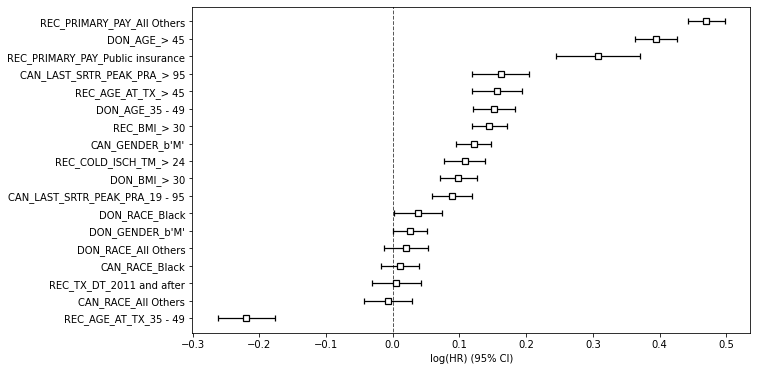

In [26]:
plt.subplots(figsize = (10, 6))
cph.plot()

### We can plot the ranking of variables in terms of their log(HR) using the .plot( ) method.

<AxesSubplot:xlabel='HR (95% CI)'>

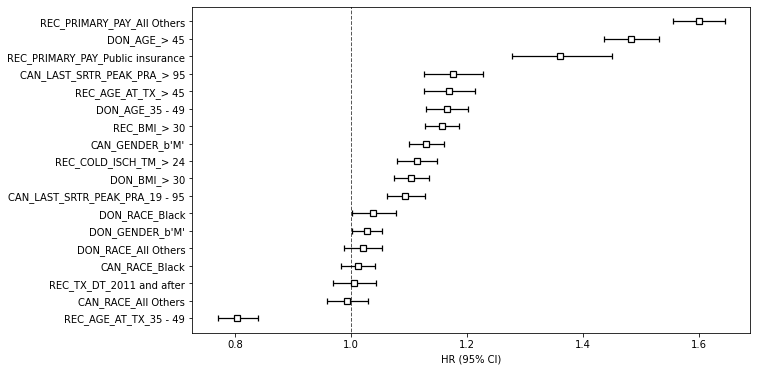

In [33]:
plt.subplots(figsize = (10, 6))
cph.plot(hazard_ratios=True)

### Goodness of fit

In [ ]:
Log-likelihood  = -264093.99
Akaike information criterion (AIC) = 528223.97 (Partial AIC)
Concordance Index = 0.60

In [ ]:
Concordance Index
This measure evaluates the accuracy of the ranking of predicted time. 
It is a generalization of AUC, another common loss function, and is interpreted similarly:
0.5 is the expected result from random predictions,
1.0 is perfect concordance and,
0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

Fitted survival models typically have a concordance index between 0.55 and 0.75 
(this may seem bad, but even a perfect model has a lot of noise than can make a high score impossible).

It is a commonly used most commonly for performance evaluation for survival models. It is used for the 
validation of the predictive ability of a survival model[18]. It is the probability of concordance between
the predicted and the observed survival

If censoring is present then we shouldn’t use the mean-squared-error or the mean-absolute-error losses. 
We should opt for the concordance-index (or the c-index for short

### Checking the proportional hazards assumption

In [ ]:
To make proper inferences, we should check our Cox model is appropriate for our dataset. 
In Cox Regression, we are implicitly applying the proportional hazard assumption.
We should check if our dataset satisfies this assumption

We can directly use the check_assumptions( ) method that return a log rank test statistics.
The null (H0) hypothesis assumed that the proportional hazard criteria satisfied, 
while alternative hypothesis (H1) infer that the proportional hazard assumption criteria not met (violated).
It is the ‘fraction of all pairs of subjects whose predicted survival times are correctly ordered among all 
subjectsthat can actually be ordered

In [27]:
cph.check_assumptions(dataset_reg, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 81004 total observations, 56025 right-censored observations>
         test_name = proportional_hazard_test

---
                                       test_statistic      p  -log2(p)
CAN_GENDER_b'M'                  km              5.40   0.02      5.63
                                 rank            5.34   0.02      5.59
CAN_LAST_SRTR_PEAK_PRA_19 - 95   km              1.46   0.23      2.14
                                 rank            1.27   0.26      1.95
CAN_LAST_SRTR_PEAK_PRA_> 95      km              7.31   0.01      7.18
                                 rank           10.08 <0.005      9.38
CAN_RACE_All Others              km              0.36   0.55      0.87
                                 rank            0.61   0.44      1.20
CAN_RACE_Black                   km              0.37   0.54      0.88
                                 rank            0.33   0.57      0.82
DON_AGE_35 - 49                  km              7.17   0.01      7.07
                                 rank            7.84   0.01      7.61
DON_AGE_> 45                     km              0.51   0.48      1.07
                                 rank            0.53   0.47      1.09
DON_BMI_> 30                     km              1.71   0.19      2.39
                                 rank            1.47   0.23      2.15
DON_GENDER_b'M'                  km              2.73   0.10      3.35
                                 rank            2.33   0.13      2.97
DON_RACE_All Others              km              0.05   0.82      0.29
                                 rank            0.27   0.61      0.72
DON_RACE_Black                   km              1.90   0.17      2.57
                                 rank            1.64   0.20      2.32
REC_AGE_AT_TX_35 - 49            km              0.01   0.93      0.11
                                 rank            0.26   0.61      0.71
REC_AGE_AT_TX_> 45               km              4.49   0.03      4.87
                                 rank            3.62   0.06      4.13
REC_BMI_> 30                     km              1.22   0.27      1.89
                                 rank            1.09   0.30      1.75
REC_COLD_ISCH_TM_> 24            km              8.35 <0.005      8.02
                                 rank           10.36 <0.005      9.60
REC_PRIMARY_PAY_All Others       km              0.65   0.42      1.25
                                 rank            0.09   0.76      0.39
REC_PRIMARY_PAY_Public insurance km              1.52   0.22      2.20
                                 rank            1.40   0.24      2.08
REC_TX_DT_2011 and after         km              9.46 <0.005      8.90
                                 rank            7.96 <0.005      7.71



1. Variable 'REC_AGE_AT_TX_> 45' failed the non-proportional test: p-value is 0.0341.

   Advice: with so few unique values (only 2), you can include `strata=['REC_AGE_AT_TX_> 45', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'DON_AGE_35 - 49' failed the non-proportional test: p-value is 0.0051.

   Advice: with so few unique values (only 2), you can include `strata=['DON_AGE_35 - 49', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'CAN_LAST_SRTR_PEAK_PRA_> 95' failed the non-proportional test: p-value is 0.0015.

   Advice: with so few unique values (only 2), you can include `strata=['CAN_LAST_SRTR_PEAK_PRA_>
95', ...]` in the call in `.fit`. See documentation in link [E] below.

4. Variable 'CAN_GENDER_b'M'' failed the non-proportional test: p-value is 0.0202.

   Advice: with so few unique values (only 2), you can include `strata=['CAN_GENDER_b'M'', ...]` in
the call in `.fit`. See documentation in link [E] below.



[]

In [ ]:
In the case of this model, it is seen that we violate the proportional hazard assumption for six 
variables. This is illustrated by the p-values being less than 0.05 as well as the text in the output. 
A red flag for this scenario is when you see the survival curves for a given covariate crossover each other 
when using Kaplan-Meier.

There are various approach to deal with it, for example we can convert it to a binned category, or we can
use a parametric Cox-PH model.

# Stratification

In [ ]:
Sometimes one or more covariates may not obey the proportional hazard assumption. In this case, we can allow 
the covariate(s) to still be included in the model without estimating its effect. This is called stratification. 
At a high level, think of it as splitting the dataset into m smaller datasets, partitioned by the unique values of
the stratifying covariate(s). Each dataset has its own baseline hazard (the non-parametric part of the model), 
but they all share the regression parameters (the parametric part of the model). Since covariates are the same 
within each dataset, there is no regression parameter for the covariates stratified on, hence they will not show up
in the output. However there will be m baseline hazards under baseline_cumulative_hazard_.

In [44]:
cph = CoxPHFitter()
cph.fit(dataset_reg, duration_col='DAYS', event_col='GL', strata=['REC_AGE_AT_TX_> 45', 'DON_AGE_35 - 49', 
                                                   'CAN_LAST_SRTR_PEAK_PRA_> 95', "CAN_GENDER_b'M'",
                                                  'REC_COLD_ISCH_TM_> 24', 'REC_TX_DT_2011 and after'])

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
                   strata = ['REC_AGE_AT_TX_> 45', 'DON_AGE_35 - 49', 'CAN_LAST_SRTR_PEAK_PRA_> 95', "CAN_GENDER_b'M'", 'REC_COLD_ISCH_TM_> 24', 'REC_TX_DT_2011 and after']
      baseline estimation = breslow
   number of observations = 81004
number of events observed = 24979
   partial log-likelihood = -185781.10
         time fit was run = 2022-02-03 20:34:12 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
REC_AGE_AT_TX_35 - 49             -0.22       0.80       0.02            -0.26            -0.17                 0.77                 0.84
DON_AGE_> 45                       0.39       1.48       0.02             0.36             0.42                 1.43                 1.53
CAN_LAST_SRTR_PEAK_PRA_19 - 95     0.09       1.10       0.02             0.06             0.12                 1.07                 1.13
DON_RACE_All Others                0.02       1.02       0.02            -0.01             0.05                 0.99                 1.05
DON_RACE_Black                     0.04       1.04       0.02            -0.00             0.07                 1.00                 1.07
CAN_RACE_All Others               -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
CAN_RACE_Black                     0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04
DON_GENDER_b'M'                    0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
DON_BMI_> 30                       0.10       1.10       0.01             0.07             0.12                 1.07                 1.13
REC_BMI_> 30                       0.15       1.16       0.01             0.12             0.17                 1.13                 1.19
REC_PRIMARY_PAY_All Others         0.47       1.60       0.01             0.44             0.50                 1.55                 1.64
REC_PRIMARY_PAY_Public insurance   0.31       1.36       0.03             0.25             0.37                 1.28                 1.45

                                     z      p   -log2(p)
covariate                                               
REC_AGE_AT_TX_35 - 49            -9.83 <0.005      73.36
DON_AGE_> 45                     23.95 <0.005     418.79
CAN_LAST_SRTR_PEAK_PRA_19 - 95    6.16 <0.005      30.40
DON_RACE_All Others               1.21   0.23       2.14
DON_RACE_Black                    1.94   0.05       4.26
CAN_RACE_All Others              -0.39   0.69       0.53
CAN_RACE_Black                    0.69   0.49       1.02
DON_GENDER_b'M'                   2.08   0.04       4.72
DON_BMI_> 30                      6.91 <0.005      37.62
REC_BMI_> 30                     11.14 <0.005      93.35
REC_PRIMARY_PAY_All Others       32.98 <0.005     789.83
REC_PRIMARY_PAY_Public insurance  9.52 <0.005      69.01
---
Concordance = 0.58
Partial AIC = 371586.21
log-likelihood ratio test = 2025.35 on 12 df
-log2(p) of ll-ratio test = inf

### Cross validation

In [75]:
#Using the K-Fold Cross-Validation with the Cox Model to confirm the concordance_index
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

In [76]:
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, dataset_reg, duration_col='DAYS', event_col='GL', k=5, scoring_method="concordance_index")
#scores = k_fold_cross_validation(cph, dataset_reg, duration_col='DAYS', event_col='GL', k=3)
print(scores)

[0.5972242768881153, 0.59789009670271, 0.6000517095779493, 0.6024110470470191, 0.6039655084112359]


In [77]:
print(np.mean(scores))
#This is approximately the same concordance model we got in our CPH model

0.6003085277254059


In [78]:
print(np.mean(k_fold_cross_validation(cph, dataset_reg, duration_col='DAYS', event_col='GL', scoring_method="concordance_index")))
#can also use scoring_method="AIC"

0.6000011601483832


# PARAMETRIC SURVIVAL MODELS

In [ ]:
parametric models to consider:
-full parametric Cox model using splines,    
-Accelerated failure time models (AFT models)
        ie The Weibull AFT model
           The log-normal and log-logistic AFT models

In [ ]:
Note since lifelines parametric models do not allow for non-positive durations, we change the 0 days to 
positive by adding a few decimals

#doing this avoids the error:
ValueError: This model does not allow for non-positive durations. Suggestion: add a small
        positive value to zero elements.

In [46]:
#day=0 chnaged to 0.000001
dataset_reg['DAYS'].replace({0: 0.000001}, inplace=True) 

### Full prarmetric cox regression Model using splines

In [ ]:
Normally, the Cox model is semi-parametric, which means that its baseline hazard, ℎ0(𝑡)
h0(t), has no parametric form. This is the default for lifelines. However, it is sometimes valuable to 
produce a parametric baseline instead. A parametric baseline makes survival predictions more efficient, 
allows for better understanding of baseline behaviour, and allows interpolation/extrapolation.

In lifelines, there is an option to fit to a parametric baseline with 
1) cubic splines, or 2) piecewise constant hazards. 
Cubic splines are highly flexible and can capture the underlying data almost as well 
as non-parametric methods, and with much more efficiency.

In [48]:
#fitting various full parametric cox models using spline and ccompare via AIC
import numpy as np
from lifelines import CoxPHFitter
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

cph1 = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3, penalizer=0.1)
cph2 = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=4, penalizer=0.1)
cph3 = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)


cph1 = cph1.fit(dataset_reg, duration_col='DAYS', event_col='GL')
cph2 = cph2.fit(dataset_reg, duration_col='DAYS', event_col='GL')
cph3 = cph3.fit(dataset_reg, duration_col='DAYS', event_col='GL')


print("=====AIC=====")
print('cph1 model AIC is: ',cph1.AIC_)
print('cph2 model AIC is: ',cph2.AIC_) 
print('cph3 model AIC is: ',cph3.AIC_)


=====AIC=====
cph1 model AIC is:  476768.39756004495
cph2 model AIC is:  476728.6380118333
cph3 model AIC is:  474879.2805601481


In [ ]:
Using the lowest aic, cph3 = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3) seems the best 
fit and this model is fitted below

In [38]:
cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
cph.fit(dataset_reg, duration_col='DAYS', event_col='GL')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 81004
number of events observed = 24979
           log-likelihood = -237417.64
         time fit was run = 2022-02-03 17:49:45 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param covariate                                                                                                                                
beta_ REC_AGE_AT_TX_35 - 49             -0.22       0.80       0.02            -0.26            -0.18                 0.77                 0.84
      REC_AGE_AT_TX_> 45                 0.15       1.17       0.02             0.12             0.19                 1.12                 1.21
      DON_AGE_35 - 49                    0.15       1.17       0.02             0.12             0.18                 1.13                 1.20
      DON_AGE_> 45                       0.40       1.48       0.02             0.36             0.43                 1.44                 1.53
      CAN_LAST_SRTR_PEAK_PRA_19 - 95     0.09       1.09       0.02             0.06             0.12                 1.06                 1.13
      CAN_LAST_SRTR_PEAK_PRA_> 95        0.14       1.15       0.02             0.10             0.19                 1.11                 1.20
      DON_RACE_All Others                0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
      DON_RACE_Black                     0.04       1.04       0.02             0.01             0.08                 1.01                 1.08
      CAN_RACE_All Others               -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
      CAN_RACE_Black                     0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
      CAN_GENDER_b'M'                    0.12       1.13       0.01             0.09             0.15                 1.10                 1.16
      DON_GENDER_b'M'                    0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
      DON_BMI_> 30                       0.10       1.10       0.01             0.07             0.13                 1.07                 1.13
      REC_BMI_> 30                       0.14       1.15       0.01             0.12             0.17                 1.13                 1.18
      REC_PRIMARY_PAY_All Others         0.47       1.59       0.01             0.44             0.49                 1.55                 1.64
      REC_PRIMARY_PAY_Public insurance   0.30       1.35       0.03             0.24             0.36                 1.27                 1.44
      REC_COLD_ISCH_TM_> 24              0.11       1.11       0.02             0.08             0.14                 1.08                 1.15
      REC_TX_DT_2011 and after           0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
      Intercept                         -5.90       0.00       0.05            -6.00            -5.80                 0.00                 0.00
phi1_ Intercept                          0.35       1.42       0.01             0.34             0.36                 1.40                 1.44
phi2_ Intercept                          0.20       1.22       0.01             0.17             0.22                 1.19                 1.24
phi3_ Intercept                         -0.64       0.53       0.03            -0.69            -0.59                 0.50                 0.56

                                             z      p   -log2(p)
param covariate                                                 
beta_ REC_AGE_AT_TX

In [ ]:
n_baseline_knots (int) – Used when baseline_estimation_method="spline". 
Set the number of knots (interior & exterior) in the baseline hazard, which will be placed evenly along the 
time axis. Should be at least 2. Royston et. al, the authors of this model, suggest 4 to start, 
but any values between 2 and 8 are reasonable.

# The Weibull AFT model

In [ ]:
The most common Accelerated failure time(AFT) model is the Weibull form.

In [109]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
aft.fit(dataset_reg, duration_col='DAYS', event_col='GL')

aft.print_summary(3) #3 decimal places

<lifelines.WeibullAFTFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
   number of observations = 81004
number of events observed = 24979
           log-likelihood = -241141.903
         time fit was run = 2022-02-03 02:26:45 UTC

---
                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                
lambda_ CAN_GENDER_b'M'                  -0.117      0.889      0.014           -0.144           -0.090                0.865                0.914
        CAN_LAST_SRTR_PEAK_PRA_19 - 95   -0.088      0.916      0.016           -0.119           -0.057                0.888                0.944
        CAN_LAST_SRTR_PEAK_PRA_> 95      -0.199      0.819      0.022           -0.243           -0.156                0.785                0.856
        CAN_RACE_All Others              -0.017      0.983      0.019           -0.054            0.020                0.948                1.020
        CAN_RACE_Black                   -0.028      0.973      0.015           -0.057            0.002                0.945                1.002
        DON_AGE_35 - 49                  -0.154      0.857      0.017           -0.187           -0.122                0.830                0.885
        DON_AGE_> 45                     -0.396      0.673      0.017           -0.429           -0.363                0.651                0.695
        DON_BMI_> 30                     -0.097      0.908      0.014           -0.125           -0.068                0.883                0.934
        DON_GENDER_b'M'                  -0.027      0.973      0.013           -0.053           -0.001                0.949                0.999
        DON_RACE_All Others              -0.029      0.971      0.017           -0.062            0.004                0.940                1.004
        DON_RACE_Black                   -0.034      0.966      0.019           -0.072            0.003                0.931                1.003
        REC_AGE_AT_TX_35 - 49             0.210      1.234      0.023            0.166            0.255                1.181                1.290
        REC_AGE_AT_TX_> 45               -0.163      0.850      0.020           -0.201           -0.124                0.818                0.883
        REC_BMI_> 30                     -0.138      0.871      0.014           -0.164           -0.111                0.849                0.895
        REC_COLD_ISCH_TM_> 24            -0.112      0.894      0.016           -0.144           -0.080                0.866                0.923
        REC_PRIMARY_PAY_All Others       -0.459      0.632      0.015           -0.488           -0.430                0.614                0.650
        REC_PRIMARY_PAY_Public insurance -0.309      0.734      0.033           -0.375           -0.244                0.688                0.783
        REC_TX_DT_2011 and after         -0.036      0.965      0.019           -0.074            0.002                0.929                1.002
        Intercept                         9.533  13811.688      0.032            9.470            9.596            12966.786            14711.642
rho_    Intercept                        -0.028      0.972      0.006           -0.039           -0.017                0.962                0.983

                                               z       p   -log2(p)
param   covariate                                                  
lambda_ CAN_GENDER_b'M'                   -8.499 <0.0005     55.531
        CAN_LAST_SRTR_PEAK_PRA_19 - 95    -5.614 <0.0005     25.594
        CAN_LAST_SRTR_PEAK_PRA_> 95       -8.979 <0.0005     61.670
        CAN_RACE_All Others               -0.895   0.371      1.431
        CAN_RACE_Black                    -1

In [86]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

4248.841751600599
6269.9143092440645


# The log-normal and log-logistic AFT models

In [87]:
from lifelines import LogLogisticAFTFitter
llf = LogLogisticAFTFitter().fit(dataset_reg, duration_col='DAYS', event_col='GL')
llf.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
   number of observations = 81004
number of events observed = 24979
           log-likelihood = -242200.13
         time fit was run = 2022-02-03 01:35:57 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                
alpha_ CAN_GENDER_b'M'                   -0.12       0.89       0.02            -0.15            -0.09                 0.86                 0.92
       CAN_LAST_SRTR_PEAK_PRA_19 - 95    -0.10       0.91       0.02            -0.13            -0.06                 0.87                 0.94
       CAN_LAST_SRTR_PEAK_PRA_> 95       -0.24       0.78       0.02            -0.29            -0.19                 0.75                 0.82
       CAN_RACE_All Others               -0.02       0.98       0.02            -0.06             0.02                 0.94                 1.02
       CAN_RACE_Black                    -0.03       0.97       0.02            -0.06             0.00                 0.94                 1.00
       DON_AGE_35 - 49                   -0.15       0.86       0.02            -0.19            -0.12                 0.83                 0.89
       DON_AGE_> 45                      -0.42       0.66       0.02            -0.46            -0.38                 0.63                 0.68
       DON_BMI_> 30                      -0.11       0.90       0.02            -0.14            -0.08                 0.87                 0.93
       DON_GENDER_b'M'                   -0.03       0.97       0.01            -0.06            -0.00                 0.94                 1.00
       DON_RACE_All Others               -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01
       DON_RACE_Black                    -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01
       REC_AGE_AT_TX_35 - 49              0.23       1.26       0.02             0.18             0.28                 1.20                 1.32
       REC_AGE_AT_TX_> 45                -0.16       0.85       0.02            -0.21            -0.12                 0.81                 0.89
       REC_BMI_> 30                      -0.15       0.86       0.02            -0.18            -0.12                 0.84                 0.89
       REC_COLD_ISCH_TM_> 24             -0.13       0.88       0.02            -0.17            -0.09                 0.85                 0.91
       REC_PRIMARY_PAY_All Others        -0.49       0.61       0.02            -0.52            -0.46                 0.59                 0.63
       REC_PRIMARY_PAY_Public insurance  -0.34       0.71       0.04            -0.41            -0.26                 0.66                 0.77
       REC_TX_DT_2011 and after          -0.04       0.96       0.02            -0.08             0.00                 0.92                 1.00
       Intercept                          9.33   11291.10       0.03             9.26             9.40             10545.57             12089.34
beta_  Intercept                          0.06       1.06       0.01             0.05             0.07                 1.05                 1.07

                                             z      p   -log2(p)
param  covariate                                                
alpha_ CAN_GENDER_b'M'                   -7.58 <0.005      44.74
       CAN_LAST_SRTR_PEAK_PRA_19 - 95    -5.63 <0.005      25.72
       CAN_LAST_SRTR_PEAK_PRA_> 95       -9.76 <0.005      72.38
       CAN_RACE_All Others               -1.05   0.29       1.78
       CAN_RACE_Black                    -1.68   0.09       3.41
       DON_AGE_3

In [101]:
from lifelines import LogNormalAFTFitter
lnf = LogNormalAFTFitter().fit(dataset_reg, duration_col='DAYS', event_col='GL')
lnf.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
   number of observations = 81004
number of events observed = 24979
           log-likelihood = -245498.66
         time fit was run = 2022-02-03 02:02:38 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                
mu_    CAN_GENDER_b'M'                   -0.13       0.88       0.02            -0.17            -0.09                 0.84                 0.91
       CAN_LAST_SRTR_PEAK_PRA_19 - 95    -0.13       0.88       0.02            -0.18            -0.09                 0.84                 0.92
       CAN_LAST_SRTR_PEAK_PRA_> 95       -0.44       0.65       0.03            -0.49            -0.38                 0.61                 0.69
       CAN_RACE_All Others               -0.04       0.96       0.03            -0.09             0.02                 0.91                 1.02
       CAN_RACE_Black                    -0.04       0.96       0.02            -0.08             0.00                 0.92                 1.00
       DON_AGE_35 - 49                   -0.17       0.85       0.02            -0.21            -0.12                 0.81                 0.89
       DON_AGE_> 45                      -0.50       0.60       0.02            -0.55            -0.45                 0.58                 0.64
       DON_BMI_> 30                      -0.15       0.86       0.02            -0.19            -0.10                 0.83                 0.90
       DON_GENDER_b'M'                   -0.05       0.95       0.02            -0.09            -0.01                 0.91                 0.99
       DON_RACE_All Others               -0.03       0.97       0.03            -0.08             0.02                 0.92                 1.02
       DON_RACE_Black                    -0.04       0.96       0.03            -0.09             0.02                 0.91                 1.02
       REC_AGE_AT_TX_35 - 49              0.23       1.26       0.03             0.17             0.30                 1.19                 1.35
       REC_AGE_AT_TX_> 45                -0.27       0.77       0.03            -0.32            -0.21                 0.72                 0.81
       REC_BMI_> 30                      -0.20       0.82       0.02            -0.24            -0.16                 0.79                 0.85
       REC_COLD_ISCH_TM_> 24             -0.20       0.82       0.02            -0.25            -0.15                 0.78                 0.86
       REC_PRIMARY_PAY_All Others        -0.60       0.55       0.02            -0.65            -0.56                 0.52                 0.57
       REC_PRIMARY_PAY_Public insurance  -0.42       0.65       0.05            -0.52            -0.33                 0.60                 0.72
       REC_TX_DT_2011 and after          -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
       Intercept                          9.88   19531.09       0.05             9.79             9.97             17860.85             21357.53
sigma_ Intercept                          0.75       2.12       0.00             0.74             0.76                 2.10                 2.14

                                             z      p   -log2(p)
param  covariate                                                
mu_    CAN_GENDER_b'M'                   -6.32 <0.005      31.86
       CAN_LAST_SRTR_PEAK_PRA_19 - 95    -5.60 <0.005      25.45
       CAN_LAST_SRTR_PEAK_PRA_> 95      -14.37 <0.005     153.07
       CAN_RACE_All Others               -1.40   0.16       2.63
       CAN_RACE_Black                    -1.82   0.07       3.86
       DON_AGE_35 

# Model selection for parametric models

In [ ]:
https://lifelines.readthedocs.io/en/latest/Examples.html
https://readthedocs.org/projects/lifelines/downloads/pdf/stable/

In [ ]:
Often, you don’t know a priori which parametric model to use. Each model has some assumptions built-in, but a quick
and effective method is to compare the AICs for each fitted model.
(In this case, the number of parameters for each model is the same, so really this is comparing the log-likelihood). 
The model with the smallest AIC does the best job of fitting to the data with a minimal degrees of freedom.

#### Selecting a parametric model using automated AIC

In [ ]:
lifelines has a built in function to automate AIC comparisons between univariate parametric models:

In [94]:
from lifelines.utils import find_best_parametric_model

T = dataset_reg['DAYS']
E = dataset_reg['GL']

best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")

print(best_model)


<lifelines.SplineFitter:"SplineFitter: 2 internal knot", fitted with 81004 total observations, 56025 right-censored observations>


In [ ]:
The results suggests the best univariate parametric model for our data is cox full model with a spline

#### Selecting the final parametric model by manually comparing concordance and AIC

In [68]:
#manual comparison
from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

llf = LogLogisticAFTFitter().fit(dataset_reg, duration_col='DAYS', event_col='GL')
lnf = LogNormalAFTFitter().fit(dataset_reg, duration_col='DAYS', event_col='GL')
wf = WeibullAFTFitter().fit(dataset_reg, duration_col='DAYS', event_col='GL')
cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3).fit(
    dataset_reg, duration_col='DAYS', event_col='GL')

#AIC
print("=====AIC=====")
print('Weibull AFT model AIC is: ',llf.AIC_)
print('The log-normal model AIC is: ',lnf.AIC_) 
print('log-logistic AFT model AIC is: ',wf.AIC_)
print('CPH model with spline 3 AIC is: ',cph.AIC_)

#Concord index  print(lnf.concordance_index_)
print("                                  ")
print("=====Concordance Index=====")
print('Weibull AFT model Concordance Index  is: ', llf.concordance_index_)
print('The log-normal model Concordance Index  is: ', lnf.concordance_index_)
print('log-logistic AFT model Concordance Index  is: ', wf.concordance_index_) 

=====AIC=====
Weibull AFT model AIC is:  484538.0021053366
The log-normal model AIC is:  499339.755340583
log-logistic AFT model AIC is:  482028.5530083681
log-logistic AFT model AIC is:  474879.2805601481
                                  
=====Concordance Index=====
Weibull AFT model Concordance Index  is:  0.6009212692616321
The log-normal model Concordance Index  is:  0.600335930841312
log-logistic AFT model Concordance Index  is:  0.6008567492468949


In [ ]:
By comparing using AIC, the best parametric model was CPH with spline

# FINAL MODEL

In [ ]:
Overall the CPH full parametric model with spline seems to be the best fit.
However the results are very similar to the semi-paranetric CPH as well

In [76]:
#semi-paranetric CPH
cph_semi = CoxPHFitter()
cph_semi.fit(dataset_reg, duration_col='DAYS', event_col='GL')

cph_semi.print_summary(3)

<lifelines.CoxPHFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
      baseline estimation = breslow
   number of observations = 81004
number of events observed = 24979
   partial log-likelihood = -264093.987
         time fit was run = 2022-02-03 20:08:51 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
REC_AGE_AT_TX_35 - 49            -0.219      0.803      0.022           -0.262           -0.176                0.769                0.838
REC_AGE_AT_TX_> 45                0.156      1.169      0.019            0.119            0.194                1.126                1.214
DON_AGE_35 - 49                   0.152      1.165      0.016            0.121            0.184                1.128                1.202
DON_AGE_> 45                      0.394      1.483      0.016            0.363            0.426                1.437                1.531
CAN_LAST_SRTR_PEAK_PRA_19 - 95    0.089      1.093      0.015            0.060            0.119                1.061                1.127
CAN_LAST_SRTR_PEAK_PRA_> 95       0.162      1.176      0.022            0.119            0.204                1.126                1.227
DON_RACE_All Others               0.020      1.020      0.017           -0.013            0.052                0.988                1.054
DON_RACE_Black                    0.038      1.038      0.018            0.002            0.074                1.002                1.077
CAN_RACE_All Others              -0.007      0.993      0.018           -0.043            0.029                0.958                1.029
CAN_RACE_Black                    0.011      1.011      0.014           -0.017            0.040                0.983                1.040
CAN_GENDER_b'M'                   0.122      1.129      0.013            0.095            0.148                1.100                1.159
DON_GENDER_b'M'                   0.026      1.027      0.013            0.001            0.051                1.001                1.053
DON_BMI_> 30                      0.099      1.104      0.014            0.071            0.126                1.074                1.134
REC_BMI_> 30                      0.145      1.156      0.013            0.119            0.171                1.127                1.186
REC_PRIMARY_PAY_All Others        0.470      1.600      0.014            0.442            0.498                1.556                1.645
REC_PRIMARY_PAY_Public insurance  0.308      1.361      0.032            0.244            0.371                1.277                1.450
REC_COLD_ISCH_TM_> 24             0.108      1.114      0.016            0.077            0.139                1.080                1.149
REC_TX_DT_2011 and after          0.005      1.005      0.019           -0.032            0.042                0.969                1.043

                                      z       p   -log2(p)
covariate                                                 
REC_AGE_AT_TX_35 - 49            -9.963 <0.0005     75.259
REC_AGE_AT_TX_> 45                8.168 <0.0005     51.507
DON_AGE_35 - 49                   9.472 <0.0005     68.307
DON_AGE_> 45                     24.391 <0.0005    434.082
CAN_LAST_SRTR_PEAK_PRA_19 - 95    5.874 <0.0005     27.811
CAN_LAST_SRTR_PEAK_PRA_> 95       7.436 <0.0005     43.126
DON_RACE_All Others               1.201   0.230      2.122
DON_RACE_Black                    2.042   0.041      4.602
CAN_RACE_All Others              -0.378   0.705      0.503
CAN_RACE_Black                    0.767   0.443      1.174
CAN_GENDER_b'M'                   9.050 <0.0005     62.604
DON_GENDER_b'M'                   2.048   0.041      4.624
DON_BMI_> 30                      7.026 <0.0005

In [60]:
print(np.mean(k_fold_cross_validation(cph_semi, dataset_reg, duration_col='DAYS', event_col='GL',
                                      scoring_method="concordance_index")))
#print(cph_semi.AIC_partial_)

0.6002238104975338


In [ ]:
BEST FIT MODEL

In [75]:
#CPH full parametric model with spline (BEST FIT MODEL)
cph_full = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
cph_full.fit(dataset_reg, duration_col='DAYS', event_col='GL')

cph_full.print_summary(3)

<lifelines.CoxPHFitter: fitted with 81004 total observations, 56025 right-censored observations>
             duration col = 'DAYS'
                event col = 'GL'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 81004
number of events observed = 24979
           log-likelihood = -237417.640
         time fit was run = 2022-02-03 20:08:42 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param covariate                                                                                                                                
beta_ REC_AGE_AT_TX_35 - 49            -0.219      0.803      0.022           -0.262           -0.176                0.769                0.839
      REC_AGE_AT_TX_> 45                0.154      1.166      0.019            0.116            0.191                1.123                1.211
      DON_AGE_35 - 49                   0.153      1.166      0.016            0.122            0.185                1.129                1.203
      DON_AGE_> 45                      0.395      1.484      0.016            0.363            0.427                1.438                1.532
      CAN_LAST_SRTR_PEAK_PRA_19 - 95    0.091      1.095      0.015            0.061            0.120                1.063                1.128
      CAN_LAST_SRTR_PEAK_PRA_> 95       0.144      1.154      0.022            0.101            0.186                1.106                1.205
      DON_RACE_All Others               0.025      1.025      0.017           -0.008            0.057                0.992                1.059
      DON_RACE_Black                    0.041      1.042      0.018            0.005            0.077                1.005                1.081
      CAN_RACE_All Others              -0.007      0.993      0.018           -0.043            0.029                0.958                1.030
      CAN_RACE_Black                    0.013      1.014      0.014           -0.015            0.042                0.985                1.043
      CAN_GENDER_b'M'                   0.120      1.127      0.013            0.093            0.146                1.098                1.157
      DON_GENDER_b'M'                   0.027      1.027      0.013            0.002            0.052                1.002                1.053
      DON_BMI_> 30                      0.098      1.103      0.014            0.070            0.125                1.073                1.133
      REC_BMI_> 30                      0.144      1.155      0.013            0.118            0.170                1.125                1.185
      REC_PRIMARY_PAY_All Others        0.465      1.592      0.014            0.437            0.493                1.549                1.637
      REC_PRIMARY_PAY_Public insurance  0.300      1.349      0.032            0.236            0.363                1.266                1.438
      REC_COLD_ISCH_TM_> 24             0.107      1.113      0.016            0.076            0.138                1.079                1.148
      REC_TX_DT_2011 and after          0.023      1.023      0.019           -0.014            0.060                0.986                1.061
      Intercept                        -5.901      0.003      0.049           -5.998           -5.805                0.002                0.003
phi1_ Intercept                         0.352      1.421      0.007            0.338            0.365                1.403                1.440
phi2_ Intercept                         0.196      1.216      0.011            0.174            0.218                1.190                1.243
phi3_ Intercept                        -0.636      0.529      0.026           -0.687           -0.586                0.503                0.557

                                              z       p   -log2(p)
param covariate                                                   
beta_ REC_AGE_

In [ ]:
The results are very similar for the semi and full parametric best models

In [ ]:
The following columns are not statistically significant
DON_RACE_All Others, CAN_RACE_All Others, CAN_RACE_Black, REC_TX_DT_2011 and after
Note for RACE, the reference is white 

# FEATURES SELECTION

In [ ]:
Goal: using an exhaustive list of features to fit regression model to selct most significant features

In [66]:
#use penalizer when doing feature selections ,l1_ratio parameter must in [0, 1]

In [ ]:
#cph = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # sparse solutions,